In [17]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import os

In [39]:
# get SPX (sum of previous data)
data = pd.DataFrame()
for name in os.listdir('.'):
    if '.csv' in name and name != 'VIX.csv':
        raw = pd.read_csv(name, index_col=0, parse_dates=True)
        add = pd.DataFrame(raw['close'])
        data = data.add(add, axis=0, fill_value=0)
data.rename({'close':'SPX'},axis=1,inplace=True)
display(data.head())
display(data.describe())

,SPX
date,
2014-02-21,2043.3871
2014-02-24,2056.1417
2014-02-25,2051.1438
2014-02-26,2053.2382
2014-02-27,2066.4070


,SPX
count,1258.000000
mean,2768.968118
std,569.045340
min,2042.883700
25%,2319.402900
50%,2491.279400
75%,3355.089050
max,3918.542500


Text(0.5, 1.0, 'SPX with regressions of deg 1,2,3,4')

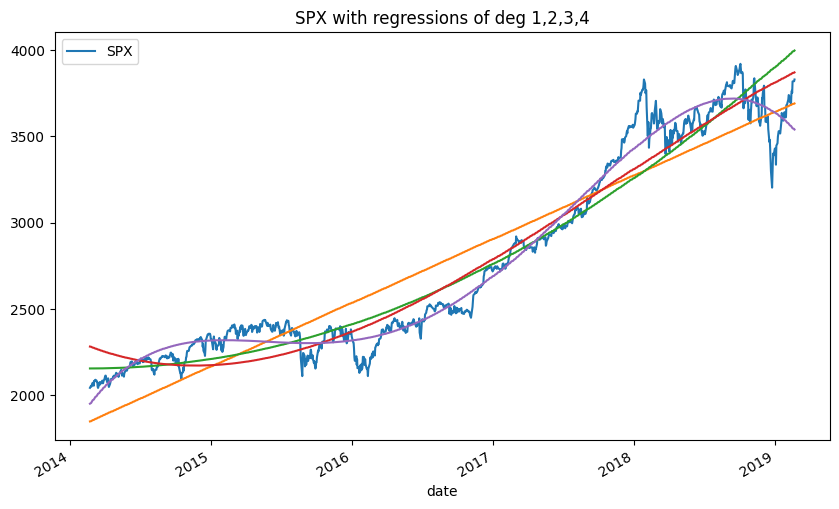

In [74]:
# regressions of degree 1,2,3,4
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data.plot(ax=ax)

for deg in [1,2,3,4]:
    reg_data = data.reset_index()
    reg = np.polyfit(reg_data.index, data.SPX, deg=deg)
    ax.plot(data.index, np.polyval(reg, reg_data.index))

ax.set_title('SPX with regressions of deg 1,2,3,4')

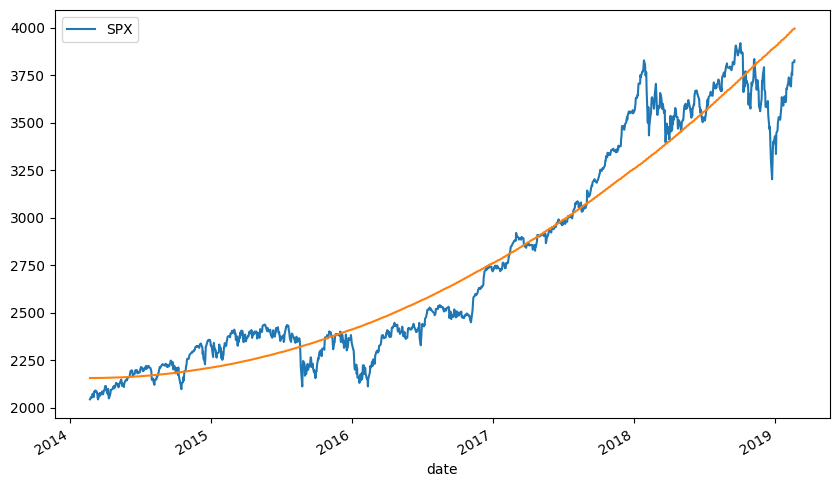

In [120]:
# regression with sin and cos
base = np.zeros((3, len(data.SPX)))
base[0:] = 1
base[1:] = reg_data.index
base[2:] = np.power(reg_data.index,2)

reg = np.linalg.lstsq(base.T, data.SPX, rcond=None)[0]
ry = np.dot(reg, base)

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data.plot(ax=ax)
ax.plot(data.index, ry)